In [ ]:
pip install numpy pandas matplotlib pyiast

In [ ]:
pip install pyiast

In [3]:
import sys
print(sys.executable)

c:\ProgramData\anaconda3\python.exe


IAST Modeling CO2/N2 at 298K

=== IAST at 298 K, 1 bar, y = [N2 0.85, CO2 0.15] ===
Total loading        : 0.85 mmol g⁻¹
Adsorbed fractions   : N2 0.050 | CO2 0.950
Selectivity CO2/N2   : 107.2

                      Component 0: p^0 = 101.038244 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 0: p^0 = 103.673053 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 0: p^0 = 106.421032 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result

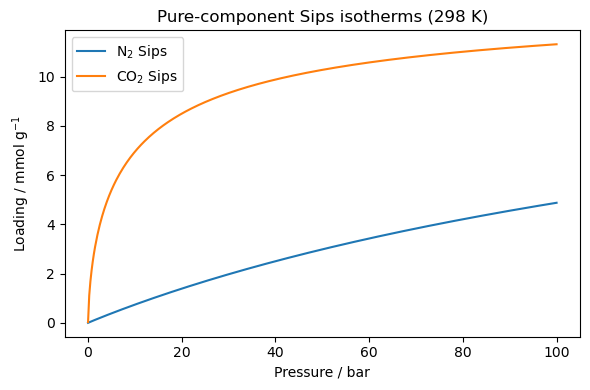

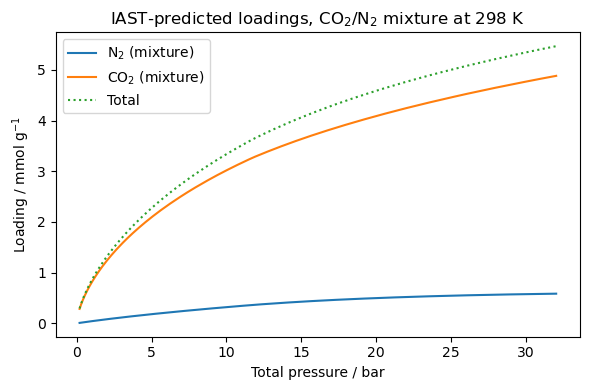

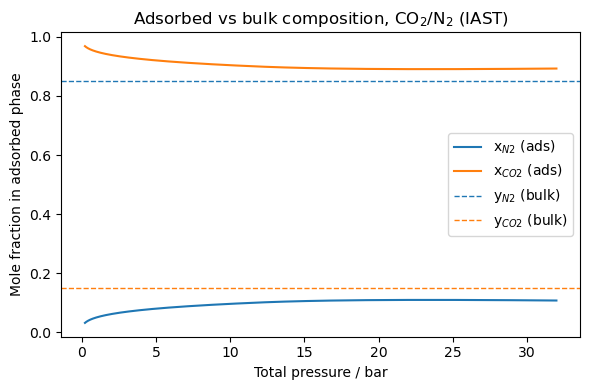

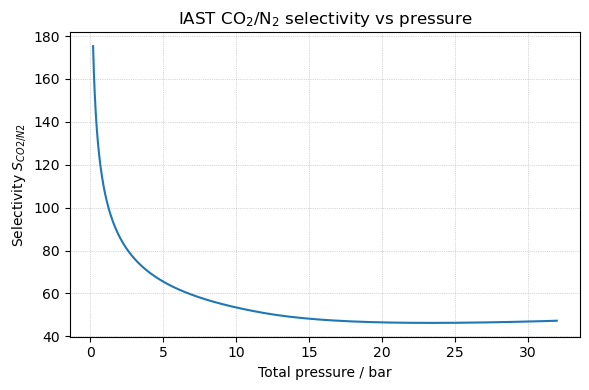

Saved figures:
  pure_isotherms_CO2_N2_298K.png
  IAST_loadings_CO2_N2_298K.png
  IAST_composition_CO2_N2_298K.png
  IAST_selectivity_CO2_N2_298K.png


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast

# ----- 1. Pure-component Sips parameters already fitted -----
pars_N2  = dict(Qm=13.85, b=0.00538, n=0.9845)   # N2 @ 298 K
pars_CO2 = dict(Qm=13.6633, b=0.1053, n=0.6677)   # CO2 @ 298 K

# Define Sips isotherm
def sips_loading(P, pars):
    Qm = pars["Qm"]
    b  = pars["b"]
    n  = pars["n"]
    # q = Qm (bP)^n / (1 + (bP)^n)
    return Qm * (b * P)**n / (1.0 + (b * P)**n)

# ----- 2. Build pyIAST isotherms (log-spaced Pgrid for IAST math) -----
# LOG-SPACED: good resolution at low P for IAST
Pgrid = np.logspace(-3, 2, 200)  # 10^-3 → 10^2 bar

q_N2  = sips_loading(Pgrid, pars_N2)
q_CO2 = sips_loading(Pgrid, pars_CO2)

df_N2  = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_N2})
df_CO2 = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CO2})

# InterpolatorIsotherm with plateau extrapolation above max P
iso_N2 = pyiast.InterpolatorIsotherm(
    df_N2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_N2["q_mmol_g"].max()   # assume saturation beyond max P
)

iso_CO2 = pyiast.InterpolatorIsotherm(
    df_CO2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CO2["q_mmol_g"].max()
)

# ----- 3. Mixture conditions -------------------------------------
y_bulk = np.array([0.85, 0.15])  # [N2, CO2]
P_tot_single = 1.0               # bar

# ----- 4. Single IAST calculation at 1 bar -----------------------
q_1bar = pyiast.iast(P_tot_single * y_bulk, [iso_N2, iso_CO2])  # [q_N2, q_CO2]

N_tot_1bar = q_1bar.sum()
x_ads_1bar = q_1bar / N_tot_1bar

select_CO2_N2_1bar = (x_ads_1bar[1] / x_ads_1bar[0]) / (y_bulk[1] / y_bulk[0])

print("=== IAST at 298 K, 1 bar, y = [N2 0.85, CO2 0.15] ===")
print(f"Total loading        : {N_tot_1bar:.2f} mmol g⁻¹")
print(f"Adsorbed fractions   : N2 {x_ads_1bar[0]:.3f} | CO2 {x_ads_1bar[1]:.3f}")
print(f"Selectivity CO2/N2   : {select_CO2_N2_1bar:.1f}")
print("================================================\n")

# ----- 5. IAST vs pressure sweep (same log-spaced grid as before) -----
# Keep log-spaced mixture pressures for consistency
P_tot_grid = np.logspace(np.log10(0.2), np.log10(32.0), 150)  # 0.2 → 32 bar

records = []
for P in P_tot_grid:
    p_part = P * y_bulk
    q = pyiast.iast(p_part, [iso_N2, iso_CO2])   # [q_N2, q_CO2]
    q_N2_mix, q_CO2_mix = q
    q_tot = q.sum()

    if q_tot > 0:
        x_ads = q / q_tot
        x_N2, x_CO2 = x_ads
        sel = (x_CO2 / x_N2) / (y_bulk[1] / y_bulk[0])
    else:
        x_N2 = x_CO2 = np.nan
        sel = np.nan

    records.append(
        dict(
            P_tot_bar=P,
            p_N2_bar=p_part[0],
            p_CO2_bar=p_part[1],
            q_N2_mmol_g=q_N2_mix,
            q_CO2_mmol_g=q_CO2_mix,
            q_tot_mmol_g=q_tot,
            x_N2=x_N2,
            x_CO2=x_CO2,
            selectivity_CO2_N2=sel,
        )
    )

df_iast = pd.DataFrame(records)
df_iast.to_csv("IAST_CO2_N2_298K_results.csv", index=False)
print("Saved IAST results to: IAST_CO2_N2_298K_results.csv")

# ----- 6. Plotting on LINEAR axes + saving figures ----------------

def save_and_show(basename):
    plt.tight_layout()
    plt.savefig(f"{basename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 6a. Pure Sips isotherms
P_plot = np.linspace(Pgrid.min(), Pgrid.max(), 400)
q_N2_plot  = sips_loading(P_plot, pars_N2)
q_CO2_plot = sips_loading(P_plot, pars_CO2)

plt.figure(figsize=(6, 4))
plt.plot(P_plot, q_N2_plot,  label="N$_2$ Sips")
plt.plot(P_plot, q_CO2_plot, label="CO$_2$ Sips")
plt.xlabel("Pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("Pure-component Sips isotherms (298 K)")
save_and_show("pure_isotherms_CO2_N2_298K")

# 6b. Mixture component loadings vs total pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["q_N2_mmol_g"], label="N$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_CO2_mmol_g"], label="CO$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_tot_mmol_g"], label="Total", linestyle=":")
plt.xlabel("Total pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("IAST-predicted loadings, CO$_2$/N$_2$ mixture at 298 K")
save_and_show("IAST_loadings_CO2_N2_298K")

# 6c. Adsorbed phase composition vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["x_N2"], label="x$_{N2}$ (ads)")
plt.plot(df_iast["P_tot_bar"], df_iast["x_CO2"], label="x$_{CO2}$ (ads)")
plt.axhline(y_bulk[0], linestyle="--", color="C0", linewidth=1, label="y$_{N2}$ (bulk)")
plt.axhline(y_bulk[1], linestyle="--", color="C1", linewidth=1, label="y$_{CO2}$ (bulk)")
plt.xlabel("Total pressure / bar")
plt.ylabel("Mole fraction in adsorbed phase")
plt.legend()
plt.title("Adsorbed vs bulk composition, CO$_2$/N$_2$ (IAST)")
save_and_show("IAST_composition_CO2_N2_298K")

# 6d. Selectivity vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["selectivity_CO2_N2"])
plt.xlabel("Total pressure / bar")
plt.ylabel("Selectivity $S_{CO2/N2}$")
plt.title("IAST CO$_2$/N$_2$ selectivity vs pressure")
plt.grid(True, linestyle=":", linewidth=0.5)
save_and_show("IAST_selectivity_CO2_N2_298K")

print("Saved figures:")
print("  pure_isotherms_CO2_N2_298K.png")
print("  IAST_loadings_CO2_N2_298K.png")
print("  IAST_composition_CO2_N2_298K.png")
print("  IAST_selectivity_CO2_N2_298K.png")


IAST Modeling CO2/N2 at 323 K

=== IAST at 323 K,1 bar, y = [N2 0.85, CO2 0.15] ===
Total loading        : 0.44 mmol g⁻¹
Adsorbed fractions   : N2 0.202 | CO2 0.798
Selectivity CO2/N2   : 22.4

                      Component 0: p^0 = 100.860292 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 0: p^0 = 104.466849 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
                      Component 0: p^0 = 108.249740 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.


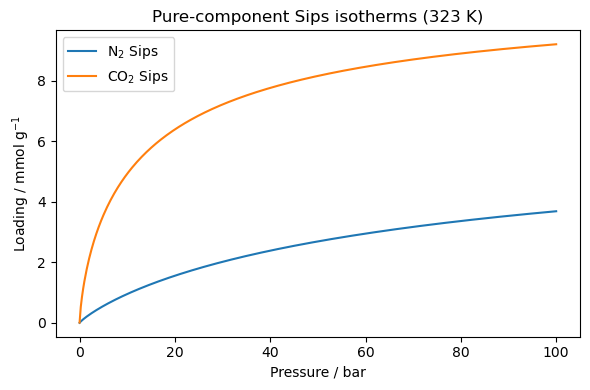

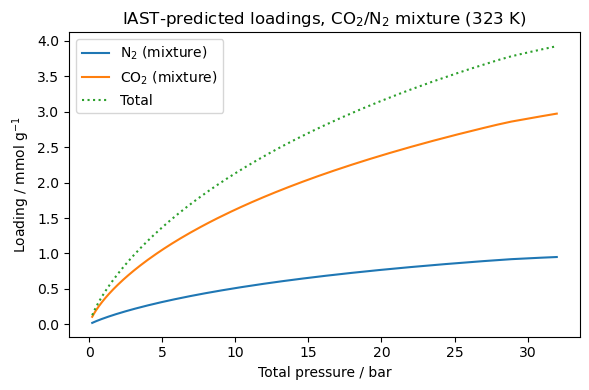

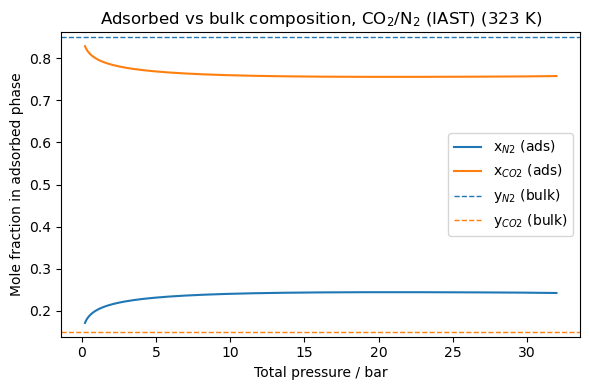

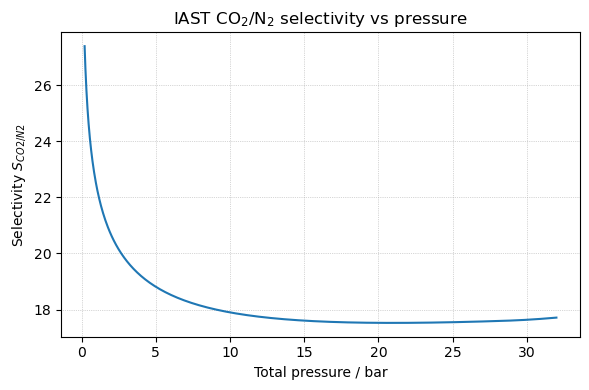

Saved figures:
  pure_isotherms_CO2_N2_323K.png
  IAST_loadings_CO2_N2_323K.png
  IAST_composition_CO2_N2_323K.png
  IAST_selectivity_CO2_N2_323K.png


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast

# ----- 1. Pure-component Sips parameters already fitted -----
pars_N2  = dict(Qm=6.67,    b=0.01275, n=0.8708)   # N2 @ 323 K
pars_CO2 = dict(Qm=11.34, b=0.0703,  n=0.7492)   # CO2 @ 323 K

# Define Sips isotherm
def sips_loading(P, pars):
    Qm = pars["Qm"]
    b  = pars["b"]
    n  = pars["n"]
    # q = Qm (bP)^n / (1 + (bP)^n)
    return Qm * (b * P)**n / (1.0 + (b * P)**n)

# ----- 2. Build pyIAST isotherms (log-spaced Pgrid for IAST math) -----
# LOG-SPACED: good resolution at low P for IAST
Pgrid = np.logspace(-3, 2, 200)  # 10^-3 → 10^2 bar

q_N2  = sips_loading(Pgrid, pars_N2)
q_CO2 = sips_loading(Pgrid, pars_CO2)

df_N2  = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_N2})
df_CO2 = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CO2})

# InterpolatorIsotherm with plateau extrapolation above max P
iso_N2 = pyiast.InterpolatorIsotherm(
    df_N2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_N2["q_mmol_g"].max()   # assume saturation beyond max P
)

iso_CO2 = pyiast.InterpolatorIsotherm(
    df_CO2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CO2["q_mmol_g"].max()
)

# ----- 3. Mixture conditions -------------------------------------
y_bulk = np.array([0.85, 0.15])  # [N2, CO2]
P_tot_single = 1.0               # bar

# ----- 4. Single IAST calculation at 1 bar -----------------------
q_1bar = pyiast.iast(P_tot_single * y_bulk, [iso_N2, iso_CO2])  # [q_N2, q_CO2]

N_tot_1bar = q_1bar.sum()
x_ads_1bar = q_1bar / N_tot_1bar

select_CO2_N2_1bar = (x_ads_1bar[1] / x_ads_1bar[0]) / (y_bulk[1] / y_bulk[0])

print("=== IAST at 323 K,1 bar, y = [N2 0.85, CO2 0.15] ===")
print(f"Total loading        : {N_tot_1bar:.2f} mmol g⁻¹")
print(f"Adsorbed fractions   : N2 {x_ads_1bar[0]:.3f} | CO2 {x_ads_1bar[1]:.3f}")
print(f"Selectivity CO2/N2   : {select_CO2_N2_1bar:.1f}")
print("================================================\n")

# ----- 5. IAST vs pressure sweep (same log-spaced grid as before) -----
# Keep log-spaced mixture pressures for consistency
P_tot_grid = np.logspace(np.log10(0.2), np.log10(32.0), 150)  # 0.2 → 32 bar

records = []
for P in P_tot_grid:
    p_part = P * y_bulk
    q = pyiast.iast(p_part, [iso_N2, iso_CO2])   # [q_N2, q_CO2]
    q_N2_mix, q_CO2_mix = q
    q_tot = q.sum()

    if q_tot > 0:
        x_ads = q / q_tot
        x_N2, x_CO2 = x_ads
        sel = (x_CO2 / x_N2) / (y_bulk[1] / y_bulk[0])
    else:
        x_N2 = x_CO2 = np.nan
        sel = np.nan

    records.append(
        dict(
            P_tot_bar=P,
            p_N2_bar=p_part[0],
            p_CO2_bar=p_part[1],
            q_N2_mmol_g=q_N2_mix,
            q_CO2_mmol_g=q_CO2_mix,
            q_tot_mmol_g=q_tot,
            x_N2=x_N2,
            x_CO2=x_CO2,
            selectivity_CO2_N2=sel,
        )
    )

df_iast = pd.DataFrame(records)
df_iast.to_csv("IAST_CO2_N2_323K_results.csv", index=False)
print("Saved IAST results to: IAST_CO2_N2_results.csv")

# ----- 6. Plotting on LINEAR axes + saving figures ----------------

def save_and_show(basename):
    plt.tight_layout()
    plt.savefig(f"{basename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 6a. Pure Sips isotherms
P_plot = np.linspace(Pgrid.min(), Pgrid.max(), 400)
q_N2_plot  = sips_loading(P_plot, pars_N2)
q_CO2_plot = sips_loading(P_plot, pars_CO2)

plt.figure(figsize=(6, 4))
plt.plot(P_plot, q_N2_plot,  label="N$_2$ Sips")
plt.plot(P_plot, q_CO2_plot, label="CO$_2$ Sips")
plt.xlabel("Pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("Pure-component Sips isotherms (323 K)")
save_and_show("pure_isotherms_CO2_N2_323K")

# 6b. Mixture component loadings vs total pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["q_N2_mmol_g"], label="N$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_CO2_mmol_g"], label="CO$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_tot_mmol_g"], label="Total", linestyle=":")
plt.xlabel("Total pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("IAST-predicted loadings, CO$_2$/N$_2$ mixture (323 K)")
save_and_show("IAST_loadings_CO2_N2")

# 6c. Adsorbed phase composition vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["x_N2"], label="x$_{N2}$ (ads)")
plt.plot(df_iast["P_tot_bar"], df_iast["x_CO2"], label="x$_{CO2}$ (ads)")
plt.axhline(y_bulk[0], linestyle="--", color="C0", linewidth=1, label="y$_{N2}$ (bulk)")
plt.axhline(y_bulk[1], linestyle="--", color="C1", linewidth=1, label="y$_{CO2}$ (bulk)")
plt.xlabel("Total pressure / bar")
plt.ylabel("Mole fraction in adsorbed phase")
plt.legend()
plt.title("Adsorbed vs bulk composition, CO$_2$/N$_2$ (IAST) (323 K)")
save_and_show("IAST_composition_CO2_N2")

# 6d. Selectivity vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["selectivity_CO2_N2"])
plt.xlabel("Total pressure / bar")
plt.ylabel("Selectivity $S_{CO2/N2}$")
plt.title("IAST CO$_2$/N$_2$ selectivity vs pressure")
plt.grid(True, linestyle=":", linewidth=0.5)
save_and_show("IAST_selectivity_CO2_N2_323K")

print("Saved figures:")
print("  pure_isotherms_CO2_N2_323K.png")
print("  IAST_loadings_CO2_N2_323K.png")
print("  IAST_composition_CO2_N2_323K.png")
print("  IAST_selectivity_CO2_N2_323K.png")

IAST Selectivity CO2 (40%)/CH4 at 298K

=== IAST at 298 K, 3 bar, y = [CH4 0.60, CO2 0.40] ===
Total loading        : 3.00 mmol g⁻¹
Adsorbed fractions   : CH4 0.107 | CO2 0.893
Selectivity CO2/CH4  : 12.5

Saved IAST results to: IAST_CO2_0.40_CH4_0.60_results.csv


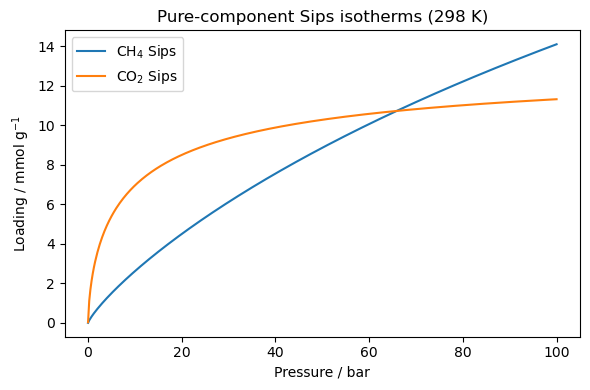

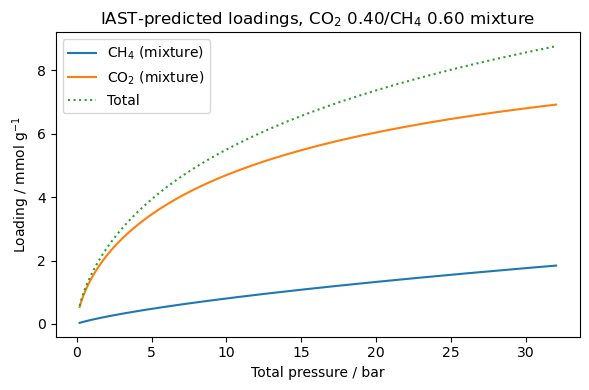

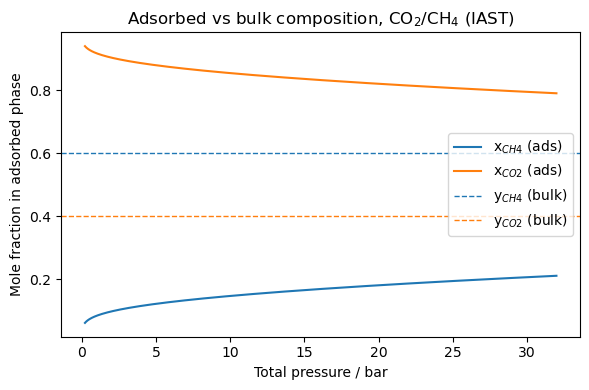

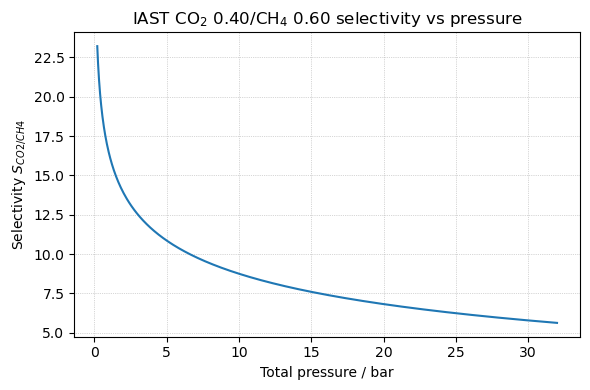

Saved figures:
  pure_isotherms_CO2_0.40_CH4_0.60.png
  IAST_loadings_CO2_0.40_CH4_0.60.png
  IAST_composition_CO2_0.40_CH4_0.60.png
  IAST_selectivity_CO2_0.40_CH4_0.60.png


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast

# ----- 1. Pure-component Sips parameters already fitted -----
pars_CH4  = dict(Qm=57.87, b=0.002566, n=0.8331)   # CH4 @ 298 K
pars_CO2 = dict(Qm=13.6633, b=0.1053, n=0.6677)   # CO2 @ 298 K

# Define your Sips isotherm
def sips_loading(P, pars):
    Qm = pars["Qm"]
    b  = pars["b"]
    n  = pars["n"]
    # q = Qm (bP)^n / (1 + (bP)^n)
    return Qm * (b * P)**n / (1.0 + (b * P)**n)

# ----- 2. Build pyIAST isotherms (log-spaced Pgrid for IAST math) -----
# LOG-SPACED: good resolution at low P for IAST
Pgrid = np.logspace(-3, 2, 200)  # 10^-3 → 10^2 bar

q_CH4 = sips_loading(Pgrid, pars_CH4)
q_CO2 = sips_loading(Pgrid, pars_CO2)

df_CH4  = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CH4})
df_CO2 = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CO2})

# InterpolatorIsotherm with plateau extrapolation above max P
iso_CH4 = pyiast.InterpolatorIsotherm(
    df_CH4,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CH4["q_mmol_g"].max()   # assume saturation beyond max P
)

iso_CO2 = pyiast.InterpolatorIsotherm(
    df_CO2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CO2["q_mmol_g"].max()
)

# ----- 3. Mixture conditions -------------------------------------
y_bulk = np.array([0.60, 0.40])  # [CH4, CO2]
P_tot_single = 3.0               # bar

# ----- 4. Single IAST calculation at 3 bar -----------------------
q_3bar = pyiast.iast(P_tot_single * y_bulk, [iso_CH4, iso_CO2])  # [q_CH4, q_CO2]
N_tot_3bar = q_3bar.sum()
x_ads_3bar = q_3bar / N_tot_3bar

select_CO2_CH4_3bar = (x_ads_3bar[1] / x_ads_3bar[0]) / (y_bulk[1] / y_bulk[0])
print("=== IAST at 298 K, 3 bar, y = [CH4 0.60, CO2 0.40] ===")
print(f"Total loading        : {N_tot_3bar:.2f} mmol g⁻¹")
print(f"Adsorbed fractions   : CH4 {x_ads_3bar[0]:.3f} | CO2 {x_ads_3bar[1]:.3f}")
print(f"Selectivity CO2/CH4  : {select_CO2_CH4_3bar:.1f}")
print("================================================\n")

# ----- 5. IAST vs pressure sweep (same log-spaced grid as before) -----
# Keep log-spaced mixture pressures for consistency
P_tot_grid = np.logspace(np.log10(0.2), np.log10(32.0), 150)  # 0.2 → 32 bar

records = []
for P in P_tot_grid:
    p_part = P * y_bulk
    q = pyiast.iast(p_part, [iso_CH4, iso_CO2])   # [q_CH4, q_CO2]
    q_CH4_mix, q_CO2_mix = q
    q_tot = q.sum()

    if q_tot > 0:
        x_ads = q / q_tot
        x_CH4, x_CO2 = x_ads
        sel = (x_CO2 / x_CH4) / (y_bulk[1] / y_bulk[0])
    else:
        x_CH4 = x_CO2 = np.nan
        sel = np.nan

    records.append(
        dict(
            P_tot_bar=P,
            p_CH4_bar=p_part[0],
            p_CO2_bar=p_part[1],
            q_CH4_mmol_g=q_CH4_mix,
            q_CO2_mmol_g=q_CO2_mix,
            q_tot_mmol_g=q_tot,
            x_CH4=x_CH4,
            x_CO2=x_CO2,
            selectivity_CO2_CH4=sel,
        )
    )

df_iast = pd.DataFrame(records)
df_iast.to_csv("IAST_CO2_0.40_CH4_0.60_results.csv", index=False)
print("Saved IAST results to: IAST_CO2_0.40_CH4_0.60_results.csv")

# ----- 6. Plotting on LINEAR axes + saving figures ----------------

def save_and_show(basename):
    plt.tight_layout()
    plt.savefig(f"{basename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 6a. Pure Sips isotherms
P_plot = np.linspace(Pgrid.min(), Pgrid.max(), 400)
q_CH4_plot  = sips_loading(P_plot, pars_CH4)
q_CO2_plot = sips_loading(P_plot, pars_CO2)

plt.figure(figsize=(6, 4))
plt.plot(P_plot, q_CH4_plot,  label="CH$_4$ Sips")
plt.plot(P_plot, q_CO2_plot, label="CO$_2$ Sips")
plt.xlabel("Pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("Pure-component Sips isotherms (298 K)")
save_and_show("pure_isotherms_CO2_CH4")

# 6b. Mixture component loadings vs total pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["q_CH4_mmol_g"], label="CH$_4$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_CO2_mmol_g"], label="CO$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_tot_mmol_g"], label="Total", linestyle=":")
plt.xlabel("Total pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("IAST-predicted loadings, CO$_2$ 0.40/CH$_4$ 0.60 mixture")
save_and_show("IAST_loadings_CO2_0.40_CH4_0.60")

# 6c. Adsorbed phase composition vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["x_CH4"], label="x$_{CH4}$ (ads)")
plt.plot(df_iast["P_tot_bar"], df_iast["x_CO2"], label="x$_{CO2}$ (ads)")
plt.axhline(y_bulk[0], linestyle="--", color="C0", linewidth=1, label="y$_{CH4}$ (bulk)")
plt.axhline(y_bulk[1], linestyle="--", color="C1", linewidth=1, label="y$_{CO2}$ (bulk)")
plt.xlabel("Total pressure / bar")
plt.ylabel("Mole fraction in adsorbed phase")
plt.legend()
plt.title("Adsorbed vs bulk composition, CO$_2$/CH$_4$ (IAST)")
save_and_show("IAST_composition_CO2_0.40_CH4_0.60")

# 6d. Selectivity vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["selectivity_CO2_CH4"])
plt.xlabel("Total pressure / bar")
plt.ylabel("Selectivity $S_{CO2/CH4}$")
plt.title("IAST CO$_2$ 0.40/CH$_4$ 0.60 selectivity vs pressure")
plt.grid(True, linestyle=":", linewidth=0.5)
save_and_show("IAST_selectivity_CO2_0.40_CH4_0.60")

print("Saved figures:")
print("  pure_isotherms_CO2_0.40_CH4_0.60.png")
print("  IAST_loadings_CO2_0.40_CH4_0.60.png")
print("  IAST_composition_CO2_0.40_CH4_0.60.png")
print("  IAST_selectivity_CO2_0.40_CH4_0.60.png")

IAST Selectivity CO2 (30%)/CH4 at 298K

=== IAST at 298 K3 bar, y = [CH4 0.70, CO2 0.30] ===
Total loading        : 2.66 mmol g⁻¹
Adsorbed fractions   : CH4 0.149 | CO2 0.851
Selectivity CO2/CH4  : 13.3

Saved IAST results to: IAST_CO2_0.30_CH4_0.70_results.csv


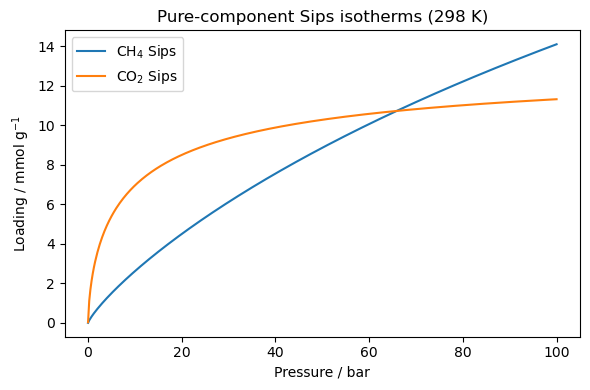

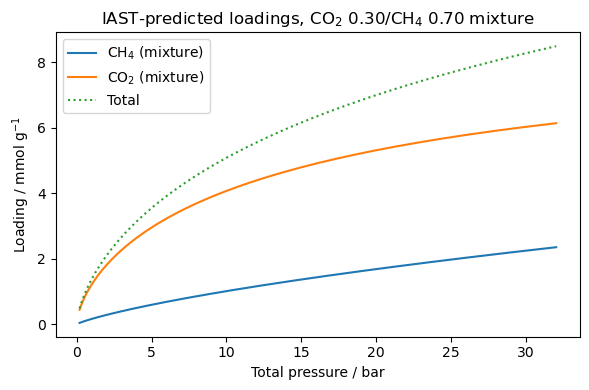

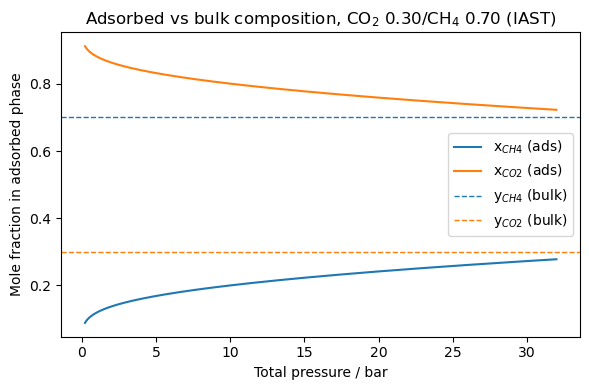

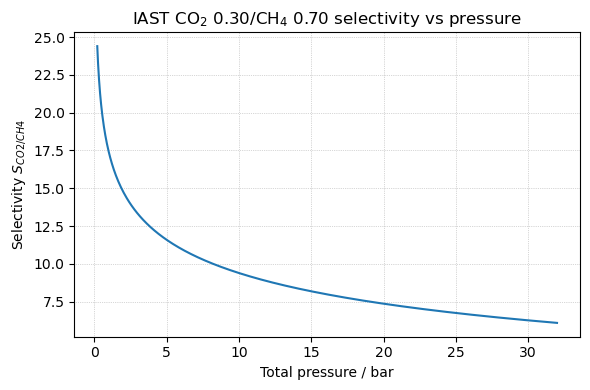

Saved figures:
  pure_isotherms_CO2_0.30_CH4_0.70.png
  IAST_loadings_CO2_0.30_CH4_0.70.png
  IAST_composition_CO2_0.30_CH4_0.70.png
  IAST_selectivity_CO2_0.30_CH4_0.70.png


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast

# ----- 1. Pure-component Sips parameters already fitted -----
pars_CH4  = dict(Qm=57.87, b=0.002566, n=0.8331)   # CH4 @ 298 K
pars_CO2 = dict(Qm=13.6633, b=0.1053, n=0.6677)   # CO2 @ 298 K

# Define Sips isotherm
def sips_loading(P, pars):
    Qm = pars["Qm"]
    b  = pars["b"]
    n  = pars["n"]
    # q = Qm (bP)^n / (1 + (bP)^n)
    return Qm * (b * P)**n / (1.0 + (b * P)**n)

# ----- 2. Build pyIAST isotherms (log-spaced Pgrid for IAST math) -----
# LOG-SPACED: good resolution at low P for IAST
Pgrid = np.logspace(-3, 2, 200)  # 10^-3 → 10^2 bar

q_CH4 = sips_loading(Pgrid, pars_CH4)
q_CO2 = sips_loading(Pgrid, pars_CO2)

df_CH4  = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CH4})
df_CO2 = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CO2})

# InterpolatorIsotherm with plateau extrapolation above max P
iso_CH4 = pyiast.InterpolatorIsotherm(
    df_CH4,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CH4["q_mmol_g"].max()   # assume saturation beyond max P
)

iso_CO2 = pyiast.InterpolatorIsotherm(
    df_CO2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CO2["q_mmol_g"].max()
)

# ----- 3. Mixture conditions -------------------------------------
y_bulk = np.array([0.70, 0.30])  # [CH4, CO2]
P_tot_single = 3.0               # bar

# ----- 4. Single IAST calculation at 3 bar -----------------------
q_3bar = pyiast.iast(P_tot_single * y_bulk, [iso_CH4, iso_CO2])  # [q_CH4, q_CO2]
N_tot_3bar = q_3bar.sum()
x_ads_3bar = q_3bar / N_tot_3bar

select_CO2_CH4_3bar = (x_ads_3bar[1] / x_ads_3bar[0]) / (y_bulk[1] / y_bulk[0])
print("=== IAST at 298 K3 bar, y = [CH4 0.70, CO2 0.30] ===")
print(f"Total loading        : {N_tot_3bar:.2f} mmol g⁻¹")
print(f"Adsorbed fractions   : CH4 {x_ads_3bar[0]:.3f} | CO2 {x_ads_3bar[1]:.3f}")
print(f"Selectivity CO2/CH4  : {select_CO2_CH4_3bar:.1f}")
print("================================================\n")

# ----- 5. IAST vs pressure sweep (same log-spaced grid as before) -----
# Keep log-spaced mixture pressures for consistency
P_tot_grid = np.logspace(np.log10(0.2), np.log10(32.0), 150)  # 0.2 → 32 bar

records = []
for P in P_tot_grid:
    p_part = P * y_bulk
    q = pyiast.iast(p_part, [iso_CH4, iso_CO2])   # [q_CH4, q_CO2]
    q_CH4_mix, q_CO2_mix = q
    q_tot = q.sum()

    if q_tot > 0:
        x_ads = q / q_tot
        x_CH4, x_CO2 = x_ads
        sel = (x_CO2 / x_CH4) / (y_bulk[1] / y_bulk[0])
    else:
        x_CH4 = x_CO2 = np.nan
        sel = np.nan

    records.append(
        dict(
            P_tot_bar=P,
            p_CH4_bar=p_part[0],
            p_CO2_bar=p_part[1],
            q_CH4_mmol_g=q_CH4_mix,
            q_CO2_mmol_g=q_CO2_mix,
            q_tot_mmol_g=q_tot,
            x_CH4=x_CH4,
            x_CO2=x_CO2,
            selectivity_CO2_CH4=sel,
        )
    )

df_iast = pd.DataFrame(records)
df_iast.to_csv("IAST_CO2_0.30_CH4_0.70_results.csv", index=False)
print("Saved IAST results to: IAST_CO2_0.30_CH4_0.70_results.csv")

# ----- 6. Plotting on LINEAR axes + saving figures ----------------

def save_and_show(basename):
    plt.tight_layout()
    plt.savefig(f"{basename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 6a. Pure Sips isotherms
P_plot = np.linspace(Pgrid.min(), Pgrid.max(), 400)
q_CH4_plot  = sips_loading(P_plot, pars_CH4)
q_CO2_plot = sips_loading(P_plot, pars_CO2)

plt.figure(figsize=(6, 4))
plt.plot(P_plot, q_CH4_plot,  label="CH$_4$ Sips")
plt.plot(P_plot, q_CO2_plot, label="CO$_2$ Sips")
plt.xlabel("Pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("Pure-component Sips isotherms (298 K)")
save_and_show("pure_isotherms_CO2_CH4")

# 6b. Mixture component loadings vs total pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["q_CH4_mmol_g"], label="CH$_4$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_CO2_mmol_g"], label="CO$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_tot_mmol_g"], label="Total", linestyle=":")
plt.xlabel("Total pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("IAST-predicted loadings, CO$_2$ 0.30/CH$_4$ 0.70 mixture")
save_and_show("IAST_loadings_CO2_0.30_CH4_0.70")

# 6c. Adsorbed phase composition vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["x_CH4"], label="x$_{CH4}$ (ads)")
plt.plot(df_iast["P_tot_bar"], df_iast["x_CO2"], label="x$_{CO2}$ (ads)")
plt.axhline(y_bulk[0], linestyle="--", color="C0", linewidth=1, label="y$_{CH4}$ (bulk)")
plt.axhline(y_bulk[1], linestyle="--", color="C1", linewidth=1, label="y$_{CO2}$ (bulk)")
plt.xlabel("Total pressure / bar")
plt.ylabel("Mole fraction in adsorbed phase")
plt.legend()
plt.title("Adsorbed vs bulk composition, CO$_2$ 0.30/CH$_4$ 0.70 (IAST)")
save_and_show("IAST_composition_CO2_0.30_CH4_0.70")

# 6d. Selectivity vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["selectivity_CO2_CH4"])
plt.xlabel("Total pressure / bar")
plt.ylabel("Selectivity $S_{CO2/CH4}$")
plt.title("IAST CO$_2$ 0.30/CH$_4$ 0.70 selectivity vs pressure")
plt.grid(True, linestyle=":", linewidth=0.5)
save_and_show("IAST_selectivity_CO2_0.30_CH4_0.70")

print("Saved figures:")
print("  pure_isotherms_CO2_0.30_CH4_0.70.png")
print("  IAST_loadings_CO2_0.30_CH4_0.70.png")
print("  IAST_composition_CO2_0.30_CH4_0.70.png")
print("  IAST_selectivity_CO2_0.30_CH4_0.70.png")

IAST Selectivity CO2(50%)/CH4 at 298 K

=== IAST at 3 bar, y = [CH4 0.50, CO2 0.50] ===
Total loading        : 3.28 mmol g⁻¹
Adsorbed fractions   : CH4 0.077 | CO2 0.923
Selectivity CO2/CH4  : 11.9

                      Component 0: p^0 = 100.517978 > 100.000000, the highest pressure
                      exhibited in the pure-component isotherm data. Thus,
                      pyIAST had to extrapolate the isotherm data to achieve
                      this IAST result.
Saved IAST results to: IAST_CO2_0.50_CH4_0.50_results.csv


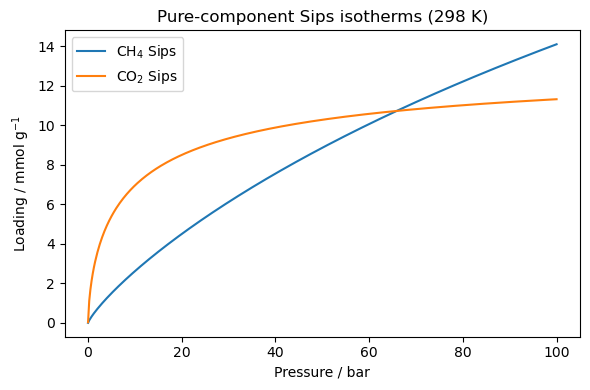

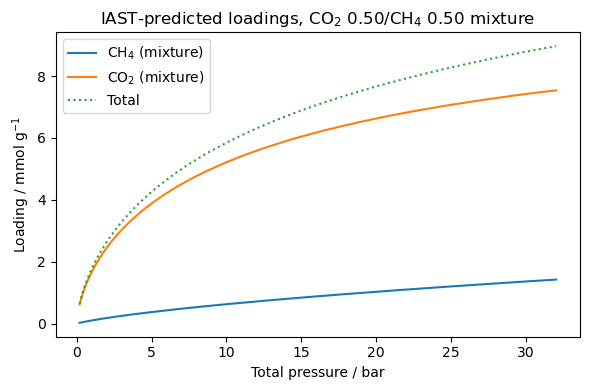

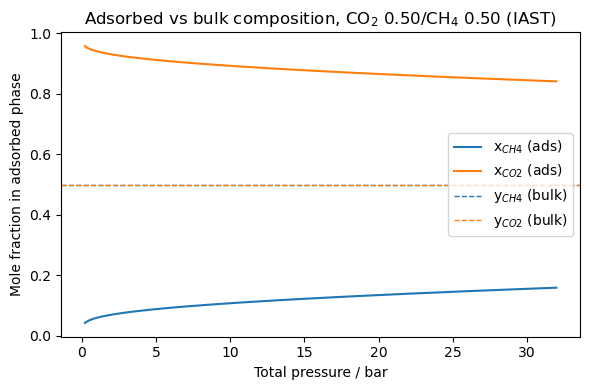

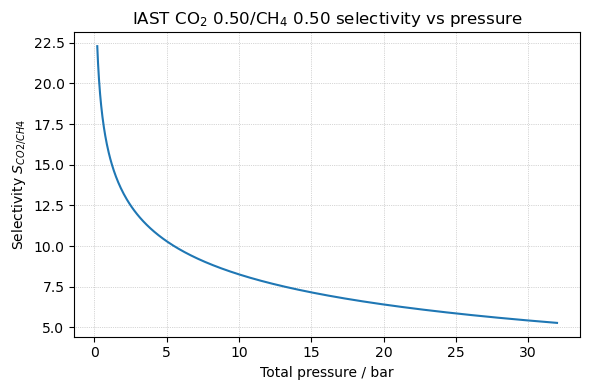

Saved figures:
  pure_isotherms_CO2_0.50_CH4_0.50.png
  IAST_loadings_CO2_0.50_CH4_0.50.png
  IAST_composition_CO2_0.50_CH4_0.50.png
  IAST_selectivity_CO2_0.50_CH4_0.50.png


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyiast

# ----- 1. Pure-component Sips parameters already fitted -----
pars_CH4  = dict(Qm=57.87, b=0.002566, n=0.8331)   # CH4 @ 298 K
pars_CO2 = dict(Qm=13.6633, b=0.1053, n=0.6677)   # CO2 @ 298 K

# Define Sips isotherm
def sips_loading(P, pars):
    Qm = pars["Qm"]
    b  = pars["b"]
    n  = pars["n"]
    # q = Qm (bP)^n / (1 + (bP)^n)
    return Qm * (b * P)**n / (1.0 + (b * P)**n)

# ----- 2. Build pyIAST isotherms (log-spaced Pgrid for IAST math) -----
# LOG-SPACED: good resolution at low P for IAST
Pgrid = np.logspace(-3, 2, 200)  # 10^-3 → 10^2 bar

q_CH4 = sips_loading(Pgrid, pars_CH4)
q_CO2 = sips_loading(Pgrid, pars_CO2)

df_CH4  = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CH4})
df_CO2 = pd.DataFrame({"P_bar": Pgrid, "q_mmol_g": q_CO2})

# InterpolatorIsotherm with plateau extrapolation above max P
iso_CH4 = pyiast.InterpolatorIsotherm(
    df_CH4,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CH4["q_mmol_g"].max()   # assume saturation beyond max P
)

iso_CO2 = pyiast.InterpolatorIsotherm(
    df_CO2,
    loading_key="q_mmol_g",
    pressure_key="P_bar",
    fill_value=df_CO2["q_mmol_g"].max()
)

# ----- 3. Mixture conditions -------------------------------------
y_bulk = np.array([0.50, 0.50])  # [CH4, CO2]
P_tot_single = 3.0               # bar

# ----- 4. Single IAST calculation at 3 bar -----------------------
q_3bar = pyiast.iast(P_tot_single * y_bulk, [iso_CH4, iso_CO2])  # [q_CH4, q_CO2]
N_tot_3bar = q_3bar.sum()
x_ads_3bar = q_3bar / N_tot_3bar

select_CO2_CH4_3bar = (x_ads_3bar[1] / x_ads_3bar[0]) / (y_bulk[1] / y_bulk[0])
print("=== IAST at 3 bar, y = [CH4 0.50, CO2 0.50] ===")
print(f"Total loading        : {N_tot_3bar:.2f} mmol g⁻¹")
print(f"Adsorbed fractions   : CH4 {x_ads_3bar[0]:.3f} | CO2 {x_ads_3bar[1]:.3f}")
print(f"Selectivity CO2/CH4  : {select_CO2_CH4_3bar:.1f}")
print("================================================\n")

# ----- 5. IAST vs pressure sweep (same log-spaced grid as before) -----
# Keep log-spaced mixture pressures for consistency
P_tot_grid = np.logspace(np.log10(0.2), np.log10(32.0), 150)  # 0.2 → 32 bar

records = []
for P in P_tot_grid:
    p_part = P * y_bulk
    q = pyiast.iast(p_part, [iso_CH4, iso_CO2])   # [q_CH4, q_CO2]
    q_CH4_mix, q_CO2_mix = q
    q_tot = q.sum()

    if q_tot > 0:
        x_ads = q / q_tot
        x_CH4, x_CO2 = x_ads
        sel = (x_CO2 / x_CH4) / (y_bulk[1] / y_bulk[0])
    else:
        x_CH4 = x_CO2 = np.nan
        sel = np.nan

    records.append(
        dict(
            P_tot_bar=P,
            p_CH4_bar=p_part[0],
            p_CO2_bar=p_part[1],
            q_CH4_mmol_g=q_CH4_mix,
            q_CO2_mmol_g=q_CO2_mix,
            q_tot_mmol_g=q_tot,
            x_CH4=x_CH4,
            x_CO2=x_CO2,
            selectivity_CO2_CH4=sel,
        )
    )

df_iast = pd.DataFrame(records)
df_iast.to_csv("IAST_CO2_CH4_results.csv", index=False)
print("Saved IAST results to: IAST_CO2_0.50_CH4_0.50_results.csv")

# ----- 6. Plotting on LINEAR axes + saving figures ----------------

def save_and_show(basename):
    plt.tight_layout()
    plt.savefig(f"{basename}.png", dpi=300, bbox_inches="tight")
    plt.show()

# 6a. Pure Sips isotherms
P_plot = np.linspace(Pgrid.min(), Pgrid.max(), 400)
q_CH4_plot  = sips_loading(P_plot, pars_CH4)
q_CO2_plot = sips_loading(P_plot, pars_CO2)

plt.figure(figsize=(6, 4))
plt.plot(P_plot, q_CH4_plot,  label="CH$_4$ Sips")
plt.plot(P_plot, q_CO2_plot, label="CO$_2$ Sips")
plt.xlabel("Pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("Pure-component Sips isotherms (298 K)")
save_and_show("pure_isotherms_CO2_0.50_CH4_0.50")

# 6b. Mixture component loadings vs total pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["q_CH4_mmol_g"], label="CH$_4$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_CO2_mmol_g"], label="CO$_2$ (mixture)")
plt.plot(df_iast["P_tot_bar"], df_iast["q_tot_mmol_g"], label="Total", linestyle=":")
plt.xlabel("Total pressure / bar")
plt.ylabel("Loading / mmol g$^{-1}$")
plt.legend()
plt.title("IAST-predicted loadings, CO$_2$ 0.50/CH$_4$ 0.50 mixture")
save_and_show("IAST_loadings_CO2_0.50_CH4_0.50")

# 6c. Adsorbed phase composition vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["x_CH4"], label="x$_{CH4}$ (ads)")
plt.plot(df_iast["P_tot_bar"], df_iast["x_CO2"], label="x$_{CO2}$ (ads)")
plt.axhline(y_bulk[0], linestyle="--", color="C0", linewidth=1, label="y$_{CH4}$ (bulk)")
plt.axhline(y_bulk[1], linestyle="--", color="C1", linewidth=1, label="y$_{CO2}$ (bulk)")
plt.xlabel("Total pressure / bar")
plt.ylabel("Mole fraction in adsorbed phase")
plt.legend()
plt.title("Adsorbed vs bulk composition, CO$_2$ 0.50/CH$_4$ 0.50 (IAST)")
save_and_show("IAST_composition_CO2_0.50_CH4_0.50")

# 6d. Selectivity vs pressure
plt.figure(figsize=(6, 4))
plt.plot(df_iast["P_tot_bar"], df_iast["selectivity_CO2_CH4"])
plt.xlabel("Total pressure / bar")
plt.ylabel("Selectivity $S_{CO2/CH4}$")
plt.title("IAST CO$_2$ 0.50/CH$_4$ 0.50 selectivity vs pressure")
plt.grid(True, linestyle=":", linewidth=0.5)
save_and_show("IAST_selectivity_CO2_0.50_CH4_0.50")

print("Saved figures:")
print("  pure_isotherms_CO2_0.50_CH4_0.50.png")
print("  IAST_loadings_CO2_0.50_CH4_0.50.png")
print("  IAST_composition_CO2_0.50_CH4_0.50.png")
print("  IAST_selectivity_CO2_0.50_CH4_0.50.png")